**🐲코더의 소회 :**  
날씨 : 오늘의 학습 < 적당히 맑음⛅ >했습니다. [☀️⛅☁️🌧️🌩️⛈️]  

**배운점 :**  
청크 단위 처리 및 병렬 처리가 대용량 데이터 읽고 처리하는데 큰 도움이 되는 것 체험하였습니다.
**아쉬운점 :**   
데이터셋 만들때 생긴 OOM 오류해결하느라 그 다음 단계로 넘어가지 못하던게 아쉽습니다. 결국 구글 코랩 유료버전 을 구매했는데 속도가 1/4로 줄어서 많이 허무했습니다. 진작 사용하걸이라는 아쉬움이 있었습니다.   
**느낀점 :**   
엔디비아 같은 하드웨어 기반 업체들이 열일해줘서 좋은 성능을 물 쓰듯 쓰고 싶습니다.👽🏭  
(참고 : https://github.com/Annyong2/AIFFEL_quest_rs/tree/master/GoingDeeper/Gdr07)   

---


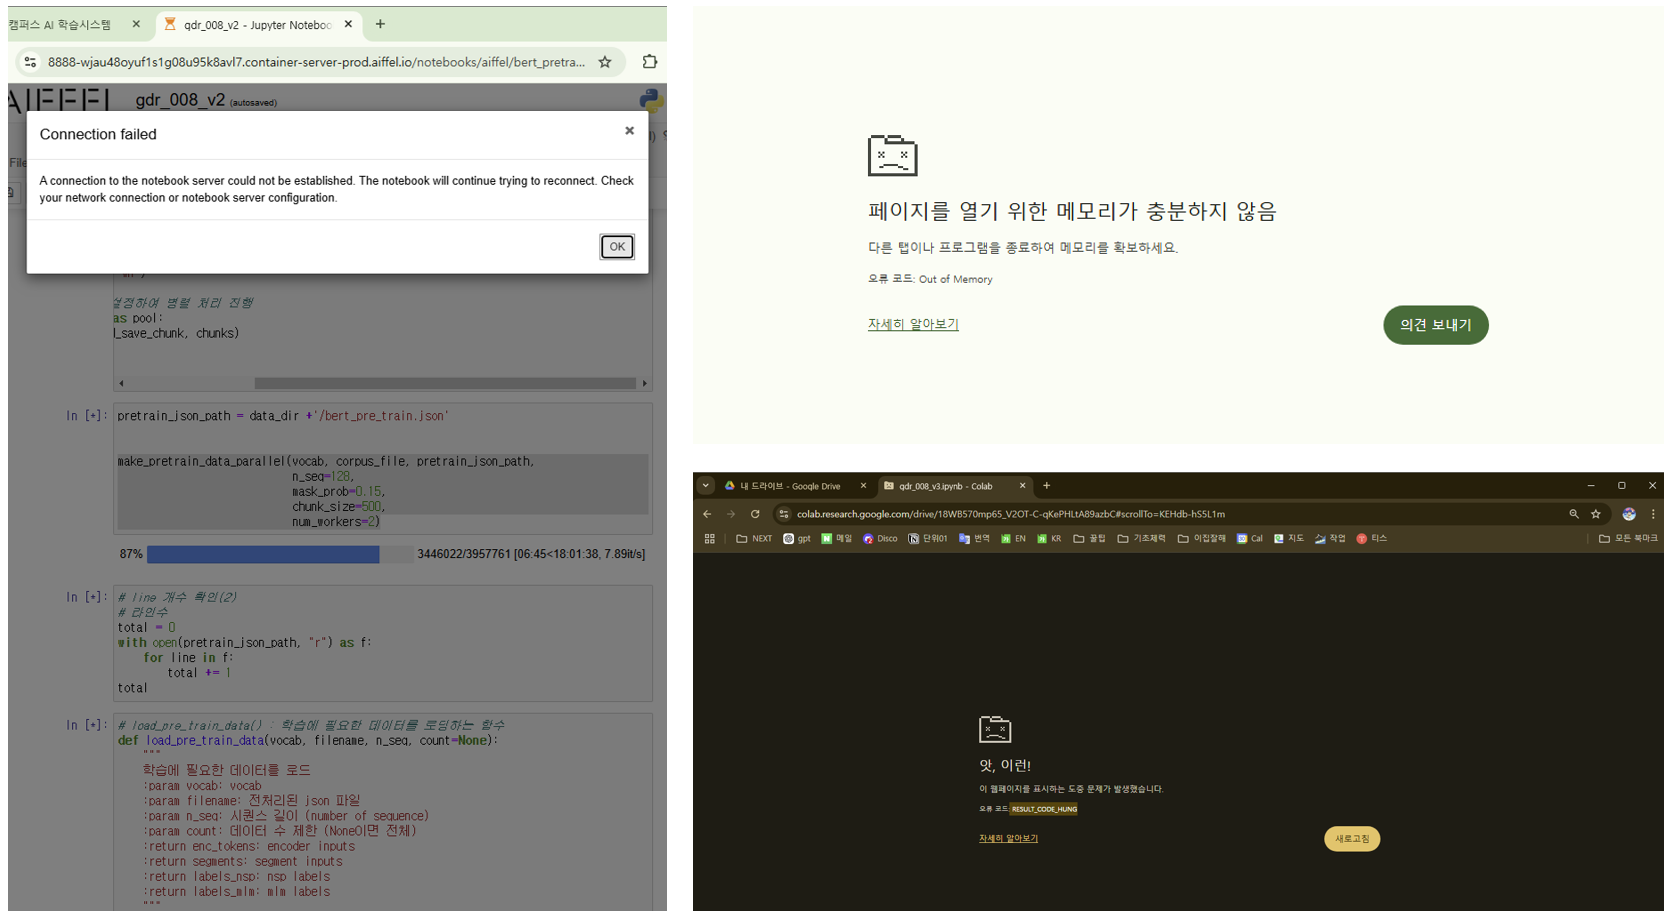   
  
---

**✅전체 코드 실행 플로우 (목차):**  
🍀STEP 0. 라이브러리 & 리소스 확인  
🍀STEP 1. Tokenizer 준비  
🍀STEP 2. 데이터 전처리 (1) MASK 생성  
🍀STEP 3. 데이터 전처리 (2) NSP pair 생성  
🍀STEP 4. 데이터 전처리 (3) 데이터셋 완성   
🍀STEP 5. BERT 모델 구현  
🍀STEP 6. pretrain 진행  
🍀STEP 7. 프로젝트 결과  


---

## 0. 라이브러리 & 리소스 확인

---

In [ ]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import json
import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm


print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(json.__version__)
print(re.__version__)

2.17.0
1.26.4
2.2.2
3.7.1
2.0.9
2.2.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import multiprocessing
# 방법 1: os 모듈 사용
cpu_count_os = os.cpu_count()
print(f"CPU 코어 수 (os): {cpu_count_os}")

# 방법 2: multiprocessing 모듈 사용
cpu_count_mp = multiprocessing.cpu_count()
print(f"CPU 코어 수 (multiprocessing): {cpu_count_mp}")

CPU 코어 수 (os): 2
CPU 코어 수 (multiprocessing): 2


## 1. Tokenizer 준비
___
SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. (시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

In [ ]:
# 경로설정
data_dir = '/content/drive/MyDrive/bert_pretrain/data'
model_dir = '/content/drive/MyDrive/bert_pretrain/model'
# 데이터 가져오기
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

In [ ]:
#특수 token 7외 나머지 token 출력
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            # [[YOUR CODE]]
            vocab_list.append(vocab)

print([vocab_list[i] for i in range(10)])
print(len(vocab_list))

[<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fe3ca4ceca0> >, <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fe3ca4ceca0> >, <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fe3ca4ceca0> >, <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fe3ca4ceca0> >, <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fe3ca4ceca0> >, <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fe3ca4ceca0> >, <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fe3ca4ceca0> >, <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type

## 2. 데이터 전처리 (1) MASK 생성
---

In [ ]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    cand_idx

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
              break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
              continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    # [[YOUR CODE]]
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

## 3. 데이터 전처리 (2) NSP pair 생성
---

In [ ]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [ ]:
# 두 문장의 최대 길이(max_seq)를 유지하도록 trim하는 함수
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [ ]:
# create_pretrain_instances() : Next Sentence Prediction을 위한 코퍼스 생성 메소드
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
         current_chunk.append(doc[i])  # line 단위로 추가
         current_length += len(doc[i])  # current_chunk의 token 수
         if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
          # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            print("current_chunk:", len(current_chunk), current_length, current_chunk)

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            print("is_next:", is_next)
            print("tokens_a:", len(tokens_a), tokens_a)
            print("tokens_b:", len(tokens_b), tokens_b)
        #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            print("tokens:", len(tokens), tokens)
            print("segment:", len(segment), segment)

            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
            print("masked tokens:", len(tokens), tokens)
            print("masked index:", len(mask_idx), mask_idx)
            print("masked label:", len(mask_label), mask_label)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
        #######################################
            print()

            current_chunk = []
            current_length = 0
    return instances

## 4. 데이터 전처리 (3) 데이터셋 완성
---

In [ ]:
# line 개수 확인(1)
corpus_file = data_dir +'/kowiki.txt'

total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

In [ ]:
'''import shutil

def make_pretrain_data_parallel(vocab, in_file, out_file, n_seq, mask_prob=0.15, chunk_size=5000, num_workers=2):
    """
    청크 단위 처리 및 병렬 처리를 도입한 pretrain 데이터 생성 함수
    각 청크를 별도의 파일로 저장한 후 최종적으로 병합하는 방식으로 메모리 사용량을 줄임.
    """
    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    with open(in_file, "r") as in_f:
        line_cnt = sum(1 for _ in in_f)

    # 데이터 청크 나누기
    chunks = []
    with open(in_file, "r") as in_f:
        current_chunk = []
        for line in tqdm(in_f, total=line_cnt):
            line = line.strip()
            if line:
                pieces = vocab.encode_as_pieces(line)
                if len(pieces) > 0:
                    current_chunk.append(pieces)
            if len(current_chunk) >= chunk_size:
                chunks.append(current_chunk)
                current_chunk = []

        # 마지막 남은 청크 추가
        if len(current_chunk) > 0:
            chunks.append(current_chunk)

    # 병렬 처리로 각 청크를 개별 파일에 저장
    def process_and_save_chunk(chunk_data, chunk_index):
        instances = create_pretrain_instances(vocab, chunk_data, n_seq, mask_prob, vocab_list)
        chunk_file_path = f"{out_file}_chunk_{chunk_index}.json"
        with open(chunk_file_path, 'w') as out_f:
            for instance in instances:
                out_f.write(json.dumps(instance, ensure_ascii=False))
                out_f.write("\n")

    # num_workers 값을 설정하여 병렬 처리 진행
    with Pool(num_workers) as pool:
        pool.starmap(
            process_and_save_chunk,
            [(chunk, idx) for idx, chunk in enumerate(chunks)]
        )

    # 청크 파일 병합
    with open(out_file, 'w') as final_f:
        for idx in range(len(chunks)):
            chunk_file_path = f"{out_file}_chunk_{idx}.json"
            with open(chunk_file_path, 'r') as chunk_f:
                shutil.copyfileobj(chunk_f, final_f)
            # 각 청크 파일 삭제
            os.remove(chunk_file_path)

'''

In [ ]:
import shutil

def process_and_save_chunk(vocab, chunk_data, out_file, n_seq, mask_prob, vocab_list, chunk_index):
    """
    각 청크 데이터를 처리하고, 결과를 파일에 저장하는 함수.
    """
    instances = create_pretrain_instances(vocab, chunk_data, n_seq, mask_prob, vocab_list)
    chunk_file_path = f"{out_file}_chunk_{chunk_index}.json"
    with open(chunk_file_path, 'w') as out_f:
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")
    print(f"Chunk {chunk_index} processed and saved.")

def make_pretrain_data_parallel(vocab, in_file, out_file, n_seq, mask_prob=0.15, chunk_size=1000, num_workers=1):
    """
    청크 단위 처리 및 순차 처리를 도입한 pretrain 데이터 생성 함수
    """
    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    with open(in_file, "r") as in_f:
        line_cnt = sum(1 for _ in in_f)

    # 데이터 청크 나누기
    chunks = []
    with open(in_file, "r") as in_f:
        current_chunk = []
        for line in tqdm(in_f, total=line_cnt):
            line = line.strip()
            if line:
                pieces = vocab.encode_as_pieces(line)
                if len(pieces) > 0:
                    current_chunk.append(pieces)
            if len(current_chunk) >= chunk_size:
                chunks.append(current_chunk)
                current_chunk = []

        # 마지막 남은 청크 추가
        if len(current_chunk) > 0:
            chunks.append(current_chunk)

    # 순차 처리로 각 청크 처리 (병렬 처리 대신 순차로 전환)
    for idx, chunk_data in enumerate(chunks):
        process_and_save_chunk(vocab, chunk_data, out_file, n_seq, mask_prob, vocab_list, idx)

    # 모든 청크 파일을 하나의 최종 파일로 병합
    with open(out_file, 'w') as final_f:
        for idx in range(len(chunks)):
            chunk_file_path = f"{out_file}_chunk_{idx}.json"
            with open(chunk_file_path, 'r') as chunk_f:
                shutil.copyfileobj(chunk_f, final_f)
            os.remove(chunk_file_path)  # 임시 파일 삭제
        print(f"All chunks have been merged into {out_file}")


In [ ]:
pretrain_json_path = data_dir + '/bert_pre_train.json'

make_pretrain_data_parallel(vocab, corpus_file, pretrain_json_path,
                            n_seq=128,
                            mask_prob=0.15,
                            chunk_size=500,  # 청크 크기를 줄여서 메모리 사용량 감소
                            num_workers=1)   # 순차 처리로 전환 (병렬 처리 제거)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [ ]:
# line 개수 확인(2)
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

In [ ]:
# load_pre_train_data() : 학습에 필요한 데이터를 로딩하는 함수
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [ ]:
# 128000건만 메모리에 로딩
count = 128000
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=count)

In [ ]:
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]


## 5. BERT 모델 구현
---

In [ ]:
# get two masks
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask
print("pad & ahead mask defined")

In [ ]:
# GELU 함수
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

print("GELU defined")

In [ ]:
# get two initializers
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer
print("kernel & bias initializer defined")

In [ ]:
# json Config
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("json Config defined")

In [ ]:
# Token Embedding 구현
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model

    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
print("Token Embedding defined")

In [ ]:
# Position Embedding
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

print("Position Embedding defined")

In [ ]:
# ScaleDot & MultiHead Attention
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
print("ScaleDotProductAttention defined")

# Q. 주석과 코드를 참조하여 아래 클래스를 완성해주세요.
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)  # (bs, 1, Q_len, K_len)  # HERE

        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        out = self.attention.call(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)  # HERE

        # Transpose and reshape output
        combined_x = tf.transpose(out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)  # HERE
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))  # (bs, Q_len, d_model)  # HERE
        attn_out = self.W_O(combined_x)

        return attn_out

print("MultiHeadAttention defined")

In [ ]:
# PFF
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
print("PositionWiseFeedForward defined")

In [ ]:
# EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

print("EncoderLayer defined")

In [ ]:
# BERT
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

print("BERT defined")

In [ ]:
# PooledOutput(Encoder Layer)
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

print("PooledOutput defined")

In [ ]:
# build_model_pre_train
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

print("Pretrained model defined")

In [ ]:
# 작은 pretrain용 BERT 모델(test_model) 생성
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

print(config)
print("config test_model")

In [ ]:
# make test inputs & test model fit
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

print("input made & model fitted")

## 6. pretrain 진행
---

In [ ]:
# loss & accuracy 함수 정의 (MLM task)

def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

print("lm_loss defined")


def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

print("lm_acc defined")

In [ ]:
# Learning Rate 스케줄링 구현(CosineSchedule) & 시각화

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("CosineSchedule defined")


# compute learning rate
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# learning rate 시각화
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [ ]:
# Actual Model Build (모델 생성)
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

print("pre_train_model completed")

In [ ]:
# optimizer & model compile
epochs = 2
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss),
                        optimizer=optimizer,
                        metrics={"nsp": "acc", "mlm": lm_acc})

print("compile completed")

## 7. 프로젝트 결과
---

In [ ]:
# keras.callbacks on history
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5",
                                                  monitor="mlm_lm_acc",
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True
                                                  )
# train
history = model.fit(
    pre_train_inputs,          # 입력 데이터
    pre_train_labels,          # 정답 레이블
    epochs=3,       # 원하는 에포크 수
    batch_size=32,   # 배치 크기
    callbacks=[save_weights]  # 콜백 리스트
)


print("callbacks on history completed")

In [ ]:
# training result 시각화
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()